# Customer review timeline (of Sea Temple Port Douglas)

## TLDR:

I explore the current trends of `customer experience` through online comments on TripAdvisor for Pullman Sea temple (PPD) in Port Douglas, Queensland, Australia.

By analysing the scores, I discovered:
- The [score distribution by comments](#how-scores-distribute). Most comments have a high score (5 bubbles/stars)!

However, when applying a `Time series analysis` I realised that:
- [Monthly average number of comments](#timeseries) has increased through the years, although
- [Score evolution](#score-through-time) shows a declining trend in recient years, and
- when counting the proportion of comments, I dicovered that despite most comments are still positive, negatives are growing

To undertand the customer experience and why the score are declining, I performed several `Text analysis` of the actual comments, to discover:
- By using multiple strategies I extrated [most common phases](#the-comments) to see which factors are the most important for customers, like the swimming pool, the distance to town or the staff
- Applying `vector similarity`, I build a [semi-unsupervised sentence classifier](#semi-unsupervised-classification-of-text) to group the text by its content in 5 categories: Housekeeping, Infrastructure, Restaurant, Front Desk and other. I later checked if their prevalence changed through time. Which wasn't the case.
- Also, I used full unsupervised [Topic modelling](#other-way-to-classify-reviews-lda) to explore more relevant topics I could miss in the first analysis.
- Then, I applied [Sentiment Analysis](#sentiment-analysis), to score how positive or negative a comment was by its content, and realised that Housekeeping has the most negative sentiment because it was higly impacted by high demand periods. 
- Finally, I validated the result with the associated score to the sentence.


---
## Context

I'm travelling throughout Australia with a WH visa. I wanted to apply for an extension of my visa. Then, to do so, I have to work either in hospitality or farm for 88 days north of the tropic. I have experience in both farms (picking fruit in New Zealand in a WH as well) and tourism (in Chile as [data] consultant), but this is not New Zealand, here there are lots of deadly animals everywhere. I’d rather work inside a Resort than in the countryside. So, I moved to Port Douglas, a very touristic hot spot.

The work is nice as a housekeeper, but I miss my analytics. Of course, before I came, I wanted to know "who is who" in this touristic hub in northern Queensland, which is close to the Daintree rainforest and one of the best spots to see the giant coral reef. 

I knew the major players and I checked their commentaries on TripAdvisor. Later, talking to one of the supervisors about customer reviews, I was taught the metrics of quality they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review through time (I mean, they read  thoughtfully and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern).

I think it is time to apply some analytics to text review the TripAdvisor reviews. I updated my webscraping script to get the data (1880 English reviews) and is time to  play.

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [15, 7]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [2]:
data = pd.read_csv('./tripullman/test.csv', encoding= "utf-8")
print(data.shape)
# Lets use english names for columns for clarity
data.columns = ['n_opinions', 'level', 'about', 'author','score', 'about_score', 'comment', 'address', 'date', 
'location','name', 'region', 'type','type1', 'title', 'link']

(1880, 16)


In [3]:
data.head(3)

,n_opinions,level,about,author,score,about_score,comment,address,date,location,name,region,type,type1,title,link
0,"1,915 reviews",6,Pullman Port Douglas Sea Temple Resort & Spa,Neil O,30,4.5,5 star prices and 3 star service. We stayed in...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",14 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",First family holiday,https://www.tripadvisor.com.au/Hotel_Review-g2...
1,"1,915 reviews",7,Pullman Port Douglas Sea Temple Resort & Spa,Daniel L,50,4.5,We have stayed now 2 times. The staff have alw...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",2 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",The best hotel in port Douglas,https://www.tripadvisor.com.au/Hotel_Review-g2...
2,"1,915 reviews",1,Pullman Port Douglas Sea Temple Resort & Spa,Carrie G,20,4.5,My family and I recently stayed for 5 nights a...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",5 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",Not deserving of 5 star rating,https://www.tripadvisor.com.au/Hotel_Review-g2...


In [4]:
# tidy calification scores
data.score = data.score/10

## How scores distribute

TripAdvisor has a system of bubbles (or Stars) ranking from 1 to 5. In that respect, most reviews give 5 bubbles to the resort with more than 1000 high score reviews (more than half of reviews).

In [5]:
data.score.describe()

count    1880.000000
mean        4.261170
std         0.986002
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

<AxesSubplot:title={'center':'PPDR Stars distribution'}, ylabel='# of comments'>

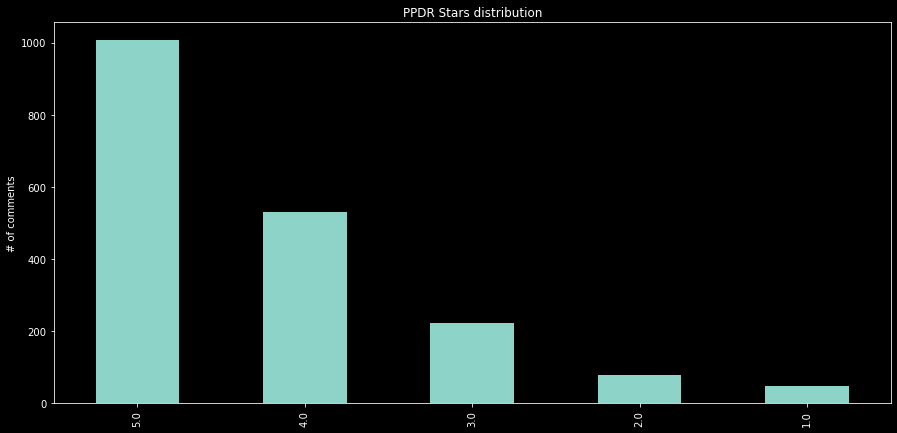

In [6]:
data.score.value_counts().plot(kind='bar', title='PPDR Stars distribution', ylabel='# of comments')

## Timeseries
 
First, let's see how many commentaries the resort has monthly.

In [26]:
data['date2'] = pd.to_datetime(data.date, format='%d %B %Y')
dfd = data.copy()
dfd.set_index(pd.DatetimeIndex(dfd['date2']), inplace=True)
dfd = dfd.sort_index()

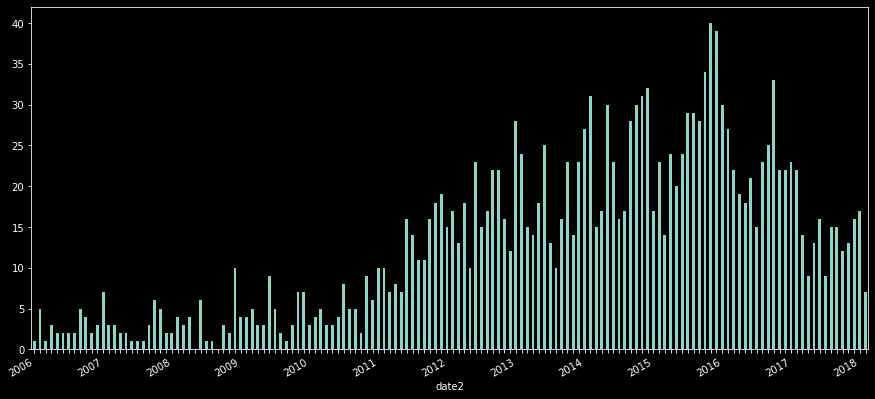

In [27]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

bar_chart = dfd.score.copy()
bar_chart = bar_chart.resample(rule='M').count()
ax = bar_chart.plot(kind='bar', x = bar_chart.index)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(bar_chart.index)
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%Y') for item in bar_chart.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.pyplot.gcf().autofmt_xdate()
plt.pyplot.show()

OK. So since 2012 comments are 20 each month, reaching a pick in 2017 up to 40 comments in a single month.

### Score through time

Let's calculate the score average for every month.

<AxesSubplot:xlabel='date2'>

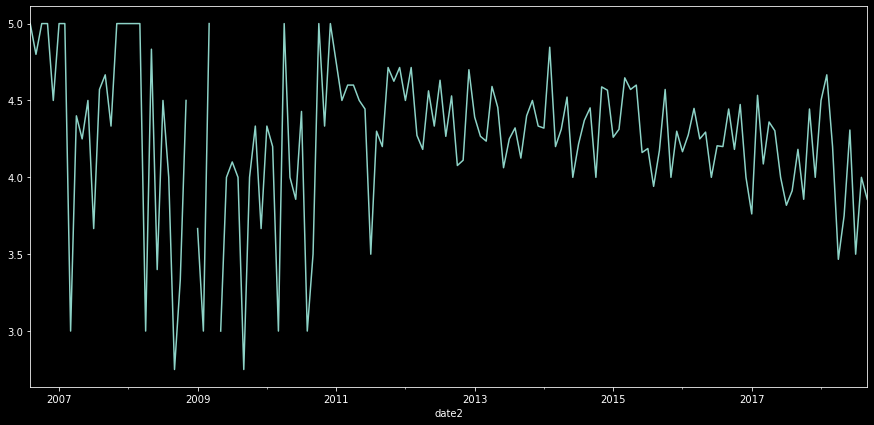

In [28]:
linear = dfd.score.copy()
linear = linear.resample(rule='M').mean()
linear.plot(kind='line')

It seems that before 2012 -when there is few comments- the mean is quite volatile, but then moves aroud 4.5 and its been slighly decreasing. More stable number could be the accumulate version.

<AxesSubplot:xlabel='date2'>

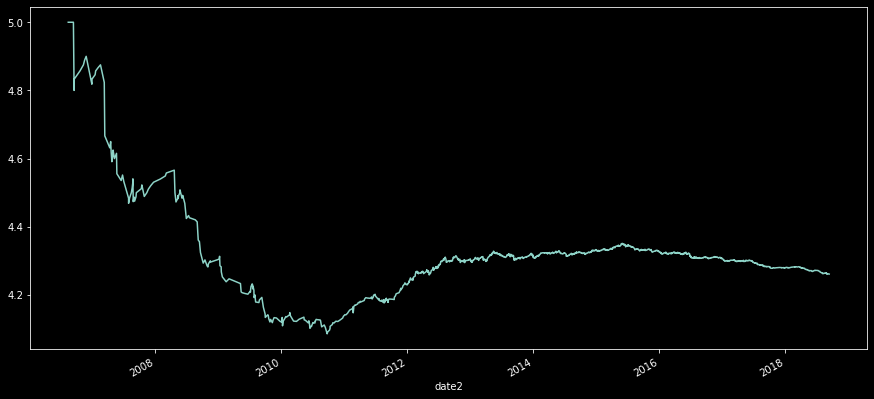

In [29]:
dfd.score.expanding().mean().plot()

The mean becomes more stable as more reviews are added, therefore, to change a reputation over time requires a lot of comments of the opposite sign. It means that the initial good reputation was easily lowered at the beginning by a few bad comments but then reverse easily as well. But then, when it reaches a plateau, change is more subtle. So, the slight decrease, in the end, could be hiding something.

Let's see the distribution of reviews over time if we normalize the number of reviews. Just take data from 2014 and on to take the initial noise out.

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/1717900909.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  calification = calification.drop('total', 1) #erase total column


<AxesSubplot:title={'center':'Monthly proportion of comments by score'}, xlabel='date2', ylabel='% of comments'>

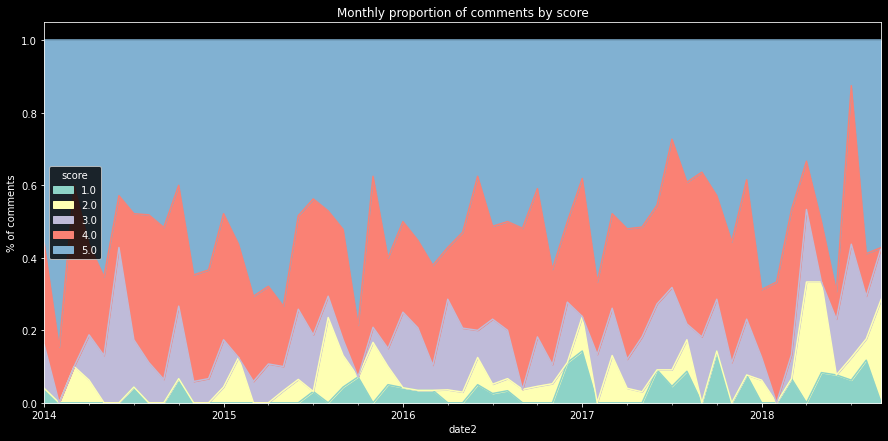

In [34]:
calification = pd.crosstab(dfd.date2, dfd.score)
calification = calification.resample(rule='M').sum()
calification['total'] = calification.sum(axis=1) # calculate a horizontal sum as total
calification = calification.div(calification.total, 0) # divide each column again total column
calification = calification.drop('total', 1) #erase total column
#calification=pd.concat([calification], keys=calification.index.year, names=['ano'])
calification.loc['2014':,:].plot(kind='area', ylabel="% of comments", title= "Monthly proportion of comments by score")
#calification.head()

It seems that the last year scores lower than 3 are more common than before. What if we compare year after year.

<AxesSubplot:title={'center':'Year 2018'}, xlabel='date2'>

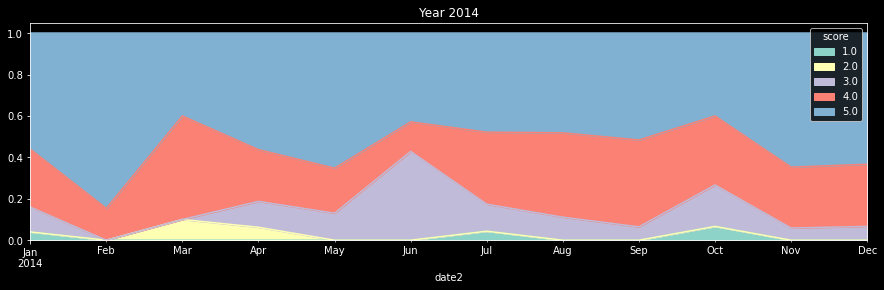

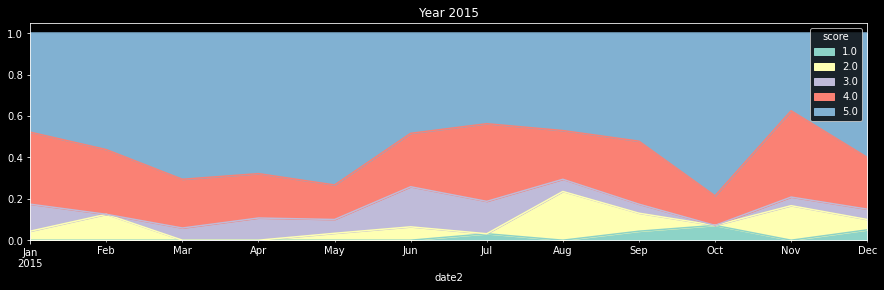

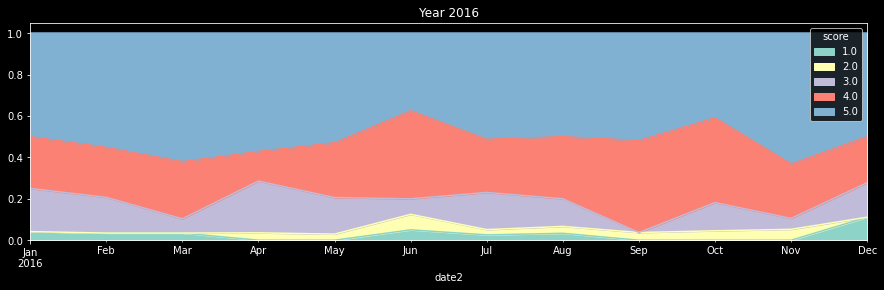

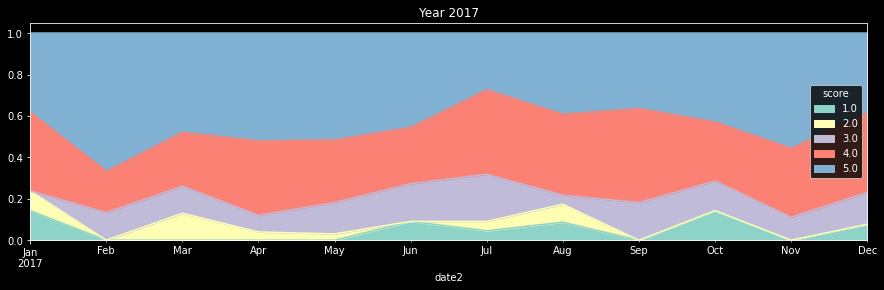

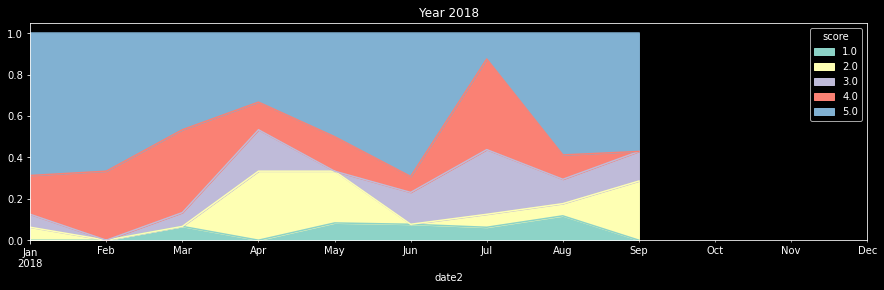

In [44]:
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
for year, i in zip(years[:-1], range(len(years)-1)):
    calification.loc[year:year,:].plot(kind='area',figsize=(15,4),sharex=True, title="Year {}".format(year))
calification.loc['2018':'2018',:].plot(kind='area',figsize=(15,4),xlim=(pd.Timestamp('2018-01-31 00:00:00', tz=None),
pd.Timestamp('2018-12-01 00:00:00', tz=None)), title="Year {}".format('2018'))

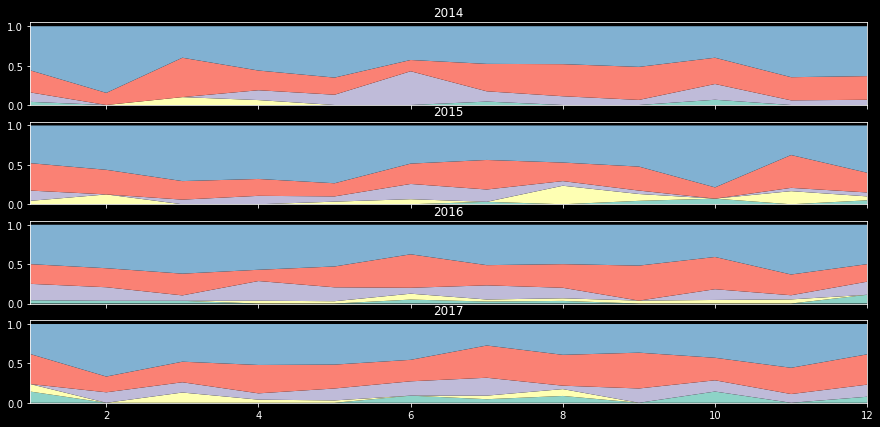

In [46]:
# Just for practice. Can I put all years in a single multi-plot?
from matplotlib import dates
fig, ax = plt.pyplot.subplots(4, 1, sharex='col', sharey='row')
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
x_dates = calification.index.month.sort_values().unique()
for year, i in zip(years[:-1], range(len(years)-1)):
    c=calification.loc[year:year,:]
    ax[i].stackplot(c.index.month,c[c.columns[0]],c[c.columns[1]],c[c.columns[2]],c[c.columns[3]],c[c.columns[4]])
    #ax[i].xaxis_date()
    #ax[i].xaxis.set_major_formatter(plt.pyplot.FixedFormatter(x_dates))
    #ax[i].xaxis.set_major_formatter(dates.DateFormatter('\n%b'))
    ax[i].set_xlim(1,12)
    ax[i].set_title(year)
    #ax[i].

In the last year there are more negatives comments. Something not good is happening.

## The Comments

Despite previous observations, many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the difference if a comment is about more than one subject.

### Prepare text data and split reviews into sentences

In [53]:
from nltk.tokenize import word_tokenize, sent_tokenize
dm = data[['title','score','comment','date']].copy()
dm.dropna(inplace=True)
dm['sent']=dm.comment.apply(sent_tokenize)
dm2 = (dm['sent'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sent').join(dm[['title','score','comment','date']], how='left'))

Check the new data set with a sentence by row.

In [54]:
dm3=dm2.reset_index().copy()
dm3.head()

,index,sent,title,score,comment,date
0,0,5 star prices and 3 star service.,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
1,0,We stayed in a villa with a private pool which...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
2,0,The maintenance man even said it’s so hard to ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
3,0,The food is bang average not just at the hotel...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
4,0,The staff are all great and try and make your ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018


## Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content first I could have a look of the most frequent words. A simple model of sklearn can give us that information. Let’s see some bi-grams and tri-grams.

In [55]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stp = nltk.corpus.stopwords.words('English') 
dm3.sent.dropna(inplace=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stp[:130] ,ngram_range = (2,3), min_df=5).fit(dm3.sent)
full_matrix = vectorizer.transform(dm3.sent)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 're', 've'] not in stop_words.
  warnings.warn(


In [57]:
def display_scores(vectorizer, tfidf_result,n=50):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print("{0:50} Score: {1}".format(item[0], item[1]))
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 189.90169447722204
port douglas                                       Score: 182.21243902619142
pool bar                                           Score: 69.29847448091986
staff friendly                                     Score: 65.5138027376518
stayed nights                                      Score: 51.820851519108004
room service                                       Score: 51.07599969858622
pool area                                          Score: 48.87967481590824
lagoon pool                                        Score: 44.75179774602524
front desk                                         Score: 43.37761076592198
golf course                                        Score: 42.37498411886369
plunge pool                                        Score: 41.55567496675205
friendly helpful                                   Score: 38.634722321888624
two bedroom                                        Score: 36.10181404189697
swimming 

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This is the most frequent combination of words in the reviews. It doesn't seem to be very meaningful. But we can collect some insights. So, besides the name of the resort, the pool and the staff are definitely the most common words (and let me tell you, the pool is upstanding), and must be a very important part of the customer experience. Let's try another technique to get more information.

### Detect keyphases

We can improve the detection of n-grams. It not only will help to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [59]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = [i for i in dm3.sent]
#data_words = dm3.sent.apply(word_tokenize)
data_words = [simple_preprocess(i,deacc=True) for i in data_words]
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


Now we check how one sentence looks once we created the n-grams.

In [60]:
print(trigram_mod[bigram_mod[data_words[632]]])

['me', 'and', 'my', 'husband', 'visited', 'port_douglas', 'for', 'short', 'stay', 'and', 'booked', 'an', 'accomodation', 'at', 'pullman_sea_temple', 'port_douglas']


Seems to work. Now I can clean the sentences and apply the ngram model it to the whole corpus.

In [61]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stp] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text = remove_stopwords(data_words)
text = make_bigrams(text)
text = make_trigrams(text)

In [62]:
dm3.sent = text
dm3.sent = dm3.sent.apply(' '.join)

People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor of the Since we have some "new words" created on n-grams let’s try to check if I can create some keyphrases. For that, I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases. resort.

In [74]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words], vector_size=100)
bigram_model_counter = Counter()
for key in bigram_model.wv.key_to_index.keys():
    if key not in stp:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.key_to_index[key]

In [77]:
for key, counts in bigram_model_counter.most_common(30):
    print('{0} \t {1}'.format(key.encode("utf-8"), counts))

b'north_queensland' 	 1829
b'seafood_platter' 	 1742
b'open_plan' 	 1576
b'ever_seen' 	 1565
b'air_conditioning' 	 1560
b'sheraton_mirage' 	 1554
b'top_notch' 	 1542
b'rain_forest' 	 1514
b'air_con' 	 1494
b'taken_care' 	 1434
b'until_pm' 	 1422
b'month_old' 	 1414
b'wet_season' 	 1400
b'far_north' 	 1396
b'tucked_away' 	 1390
b'hiring_car' 	 1369
b'wi_fi' 	 1353
b'sun_loungers' 	 1272
b'shuttle_buses' 	 1268
b'assistant_manager' 	 1263
b'th_birthday' 	 1257
b'hired_car' 	 1255
b'deck_chairs' 	 1231
b'upon_arrival' 	 1228
b'walking_distance' 	 1221
b'lucky_enough' 	 1208
b'sun_lounges' 	 1201
b'through_boutique' 	 1200
b'high_standard' 	 1168
b'self_catering' 	 1151


Now it looks like we can found some meaning on them. Let's check a couple interesting ones within context.

In [78]:
pd.set_option('display.max_colwidth', -1)
dm3[['sent','comment']][dm3.sent.str.contains("front_desk")].sample(5)

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/3153854711.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,sent,comment
7753,want spa services book arrive asked front_desk arrived book spa day till later book told called day wanted services completely booked known better going told upon check,"This resort is great. The pool is great, lots of space. We only did breakfast at the restaurant and it was very good. The room service was great as well. As like all of Port Douglas, there are cane toads everywhere, stay away they are poisonous to human and animals. Port Douglas is a wonderful town. If you plan on staying for several days, pay the price for the 5 day or 3 day passes on the shuttle, you will surely use it because you can't walk to places and the town with restaurants and shopping is about 8 minutes away. There is a grocery store in town also. We stayed in the two bedroom penthouse and it was magnificent. Lots of room, private hot tub, rooftop terrace and balcony. This hotel is great, the staff was wonderful as well. If you have tendancy to get car sick, take some medication because the trip from cains to port douglas was horrible, lots of winding roads, probably didn't help that our shuttle driver drove like crazy and that I'm not used to being in vehicle driving on the right side of the road. The beds in this resort were very comfortable, bath was huge. If you want to have spa services book them when you arrive, I asked the front desk when I arrived if I should book the spa that day or what till later to book, I did as told and called the day before I wanted my services and they were completely booked, I should have known better but I was going off what I was told upon check in."
3611,staff excellent especially sharnee front_desk,"The resort is fabulous. The staff are excellent, especially Sharnee at front desk. She went out of her way to make our stay comfortable for us. The kids loved the pool area, we never left the resort it was that enjoyable. We will definitely be back again."
7186,could walk pretty hot call front_desk come golf cart pick,"We had just gotten off our cruise on the Crystal Cruise line in Brisbane and flew to Cairns. Had a lovely drive along the Coral Sea to Port Douglas about one hour from the airport. It reminded me of the Amalfi Coast with its winding roads and beautiful scenery. We arrived at the Sea Temple Resport and Spa and were greeted by a very friendly staff member. All the staff was wonderful and helpful when we arrived. The opened air lobby had a beautiful view of the very large pool area. We were driven by golf cart to our room. My travel agent said she got us a penthouse suite, but when we got into our apartment (which is almost that same size as our apartment in the states) we were astounded by how spacious and beautiful is was. It is decorated very tastefully with all you could want. Washer dryer, dishwasher, large refrigerator, microwave. We could easily have stayed for months. Not only were the rooms nice, but the verandah was spacious also with a couch, 2 chairs and a table. Then I noticed a spiral staircase outside and it led to an upstairs that had a hot tub, barbecue grill and table and chairs. We wanted to move right in. We were on the second floor and the first floor rooms have access to the lazy river pool right outside their verandah. There was no direct access from our room to the lobby. You could walk but it was pretty hot, so you just call the front desk and they come with the golf cart to pick you up. The staff also helped with setting up tours and gave us some restaurant tips. Too bad we were only there for 3 days. We didn't get to see everything we wanted. Took a shuttle to town one night but it was around 6 and all the stores were closed, which I thought was strange as it is a resort town. Then I was told it is off season, but we did happen upon a great restaurant called Nautilis which had a long access to the main area but once you get there you think you just entered a tropical jungle. Beautiful and very romantic. January is a tricky time of year there, it's hot but it c

It seems that the guys at frond desk are doing a great job. 

In [82]:
dm3[['sent','comment']][dm3.sent.str.contains("shuttle_bus")].sample(5)

,sent,comment
8771,draw backs per night charge cot location close town bit hassle get baby suppliies shuttle_bus though cost,"Stayed in a one bed 2nd floor apartment with the rooftop spa. Good sized apartments with a well stocked kitchen. The pool was great, perfect for our young children. The breakfast was fine, they did have an omlette chef though for some reason he did not cook eggs they had to be ordered from the staff. The only draw backs are $10 per night charge for a cot and the location is not close to town, which is a bit of a hassle to get more baby suppliies, there is a shuttle bus though cost $7. Overall a great place for a holiday though you may consider something closer to town if you plan to eat out every night or dont want to pay for a taxi home each night."
8213,spend time shuttle_bus laze around pool drinking cocktails,"We recently enjoyed a weekend at Sea Temple Port Douglas, sure it is the wet season but we took the gamble and went up any way. We are so glad we did, the weather was perfect. The resort is well planned and maintained. We had a three bedroom penthouse apartment for four nights which was booked through the apartment owners', and not the resort itself - a fact we didn't know until we got there. This meant being met by the booking agent for check in, (key handover) and not checking in at the resort desk. It also meant that if we had any queries or problems throughout our stay, that we would contact the booking agent and not the concierge or front desk. Our room included a rooftop spa and BBQ and not direct access to the pool which really wasn't a problem as the pool is very easily access able anyway. Being summer the rooftop spa wasn't very refreshing so we didn't bother using it, but the BBQ got a great workout. The kitchen was very clean with an oven big enough to accommodate our needs. Although this resort has a shuttle bus, I recommend car hire for the convenience of it and also the time saving factor. Why spend time in the shuttle bus when you can laze around the pool drinking cocktails. Give yourself plenty of time when ordering drinks, on the first day our drinks took two and a half hours to arrive, apparently the barman didn't have enough glasses despite the being used glasses and plates lying around waiting for clean up from areas of private access from ground floor rooms."
2485,stayed days used shuttle_bus get port_douglas quite good easy make_sure organise suitable pass otherwise paying trip,"Travelled to Port Douglas with teenagers, the Pullman has a wonderful pool and is about a 1 hour walk into Port Douglas along the beach. Stayed for 6 days and used shuttle bus to get into Port Douglas which was quite good and easy, make sure you organise a suitable pass otherwise you will be paying for each trip! Pullman had quite alot of very young kids (not well supervised) there was a lot of morning noise, particularly if you get a swim out pool room which is what we had. Staff were lovely and room staff were particularly helpful."
7142,location bit port_douglas shuttle_bus ran every hour though bit pricey person,"First rate hotel. Beautiful grounds with its massive pool as the centerpiece. Many of the rooms back up to the pool which would be perfect if you were traveling with kids. The rooms were modern but with some definate negatives. First, the room was sparsely furnished. Not room for any furniture other than a small sitting table in the corner of the room. As with most of the New Zealand hotels we stayed the bed was a queen size which would not have been our first choice. Another problem was the glass enclosed bathroom. When the light was on in the bathroom it also illuminated the adjacent bedroom. Liked the shower and separate tub. The tub was so massive it took 15 minutes to even partially fill it. Still, the rooms had a very luxurious feel to them. The front desk was very helpful and booked us tickets to the Skyrail and Railway through the Kuranda Rainforest (a highlight of our trip). 

This is surprising. As the resort seems to be away from town, shuttle buses are an important factor in the customer's experience.

In [28]:
dm3[['sent','comentario']][dm3.sent.str.contains("direct_access")].sample(5)

,sent,comentario
2463,direct_access pool,"Our first night at this expensive resort was not a positive experience. We were allocated one of the worst swim out rooms in this resort, Rm 145. The room had a a damp smell, and opening it up made no difference. It was sunless, and faced a pedestrian bridge - losing privacy. It did not have direct access to the pool. Further, the furnishings were a disgrace for a 5-star experience, with damaged or discoloured fittings such as damaged lamp shades that need replacing. The beds were comfortable but the staff were unable to find a bottom sheet that actually fitted properly. (Strangely for a five star place, the sheets were not changed everyday unless you asked - which we did - and even then they were reluctant to change them more then once every 3 days!) The Front Office manager agreed to move us into a new apt the next day thankfully, though it was not very sunny despite his claim to the contrary. One of the problems at this Pullman resort, which is not reflective of other Pullmans we've seen, is that a number of the apartments are leased or owned privately, and quality seems to vary from room to room as a result. The restaurant is over priced with a limited menu and most patrons seem to eat out. On a positive note, the staff, especially the non-management staff, were all very pleasant. In sum, the Pullman Sea Temple is a lovely place with a superb pool, with great potential, but they do need to make some significant improvements in basic areas...it starts with management training and doing right by the high paying customer."
2837,available would recommend apartment plunge pool apartments direct_access main resort pool,"With two children we were very happy with the two bedroom apartment with its own outdoor area / gazebo and plunge pool (Apartment 120). It was very private yet still very close to the main resort pool and dining areas. The staff were very accommodating and we appreciated the invitation to the 10 year anniversary celebration of the resort! We opted for the morning breakfast buffet each day which offered a broad selection including eggs cooked to order and a pancake making machine which the kids enjoyed. The main resort pool was huge (bigger than Palm Cove Pullman) but the gym was small. Location great, a quick 3 minute drive to Port Douglas shops and 3 minute walk to the beach. We also stayed at the Pullman at Palm Cove and would rate Port Douglas higher and more 'exclusive.' If available we would recommend an apartment with the plunge pool over the apartments that had direct access to the main resort pool."
4101,hotel pool fabulous direct_access mile_beach added bonus,My family and I are regrettably leaving the wonderful Sea Temple after an idyllic 5 night stay to conclude our adventures around Australia. What a beautiful hotel and a lovely resort in Port Douglas. The hotel pool is fabulous and direct access to 4 mile beach is an added bonus. We couldn't fault this place at all and will definitely be back!
7809,even though room toward back resort direct_access lagoon still lovely place,"I knew that I was going to be in for a treat and I wasn't disappointed. The resort was very well resourced and had an edge over anywhere else I had stayed. It's location is out of the township of Pt Douglas, but there are cheap travel alternatives to get into town. So the distance is no hurdle at all. The walk along the beach into Port Douglas is beautiful. This trip was to recharge my batteries and it did exactly that. The staff were extremely helpful and went out of their way to help where ever needed. The room was sensational. Even though my room was toward the back of the resort and did not have direct access to the lagoon, it was still a lovely place. It was well appointed and the spa was definitely a highlight of my room. I would definitely stay there again and make the most of all Port Douglas has to offer."
9387,room swim option gives direct_access swimming pool,"The Sea Temple was

People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor of the resort.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject and adjetives of each sentences.

In [84]:
import spacy
nlp = spacy.load('en_core_web_md')

dm3['new_col'] = dm3['sent'].apply(lambda x: nlp(x))

In [85]:
#Function to extract relevant chunks
def get_chunk(sent, chunk="NOUN"):
    chunks=[]
    dep =[]
    tt = []
    for w in sent:
        if w.pos_ == chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep
     
dm3['keywords'] = dm3.new_col.apply(get_chunk)
keywords = dm3.keywords.apply(' '.join)

#print dm3.new_col.apply(lambda x: [(i.tag_,i.text) for i in x])

If we collect the most (noun) common words we could use them to classify comments later.

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
commonWords = cv.fit(keywords)
kw = commonWords.transform(keywords)
display_scores(commonWords,kw,25) 

pool                                               Score: 1503
room                                               Score: 1093
resort                                             Score: 780
staff                                              Score: 754
great                                              Score: 692
hotel                                              Score: 566
spa                                                Score: 555
apartment                                          Score: 539
service                                            Score: 453
rooms                                              Score: 433
good                                               Score: 422
restaurant                                         Score: 414
area                                               Score: 391
time                                               Score: 390
bedroom                                            Score: 361
beautiful                                          Score: 329
nights

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ok. Pool, room and staff are the most common (noun) words once again. Its seems that much of the experience are defined by those factors. Other words are not surprisingly common, as the name, "resort" and "hotel". Some others are other areas and services of the resort as the "restaurant".

But there is three that instrigin me: "area", "time", "town".
Let's see if we could get something of context for each of theses words.



In [88]:
pd.set_option('display.max_colwidth', -1)
for w in ['area','time','town']:
    print(dm3.sent[dm3.sent.str.contains(w)].sample(5))

5327    room luckily enough tucked around back school_holidays big area pool busy younger noisy kids             
113     bit wear tear upstairs jacuzzi area however would expected tropics                                       
883     room overlooked pool bar area wasnt noisy                                                                
5814    talking furniture thought arrival hall registration desk area furniture looked quite shabby need replaced
4901    one area bit disappointing food average best                                                             
Name: sent, dtype: object
193     check take time employees busy helped                                                                       
8213    spend time shuttle_bus laze around pool drinking cocktails                                                  
9112    decided go port_douglas get little away time visiting friends sea_temple perfect escape                     
5420    daughter weeks pregnant decided pullman_port_

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/4094085332.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Ok, so "area" refers to many places like bbq area. Then, "time" is about how many times a customer has been in the resort.

But the third one is the most interesting. Is the distance to the "town" that appears in the comments reflecting some of the differences with other big resorts in the area. Again, as we notice with the shuttle bus services, this is an important factor in the experience of someone staying at the resort. If they flew or they drive to Port Douglas makes a difference. This is especially true as many of the rooms are self-contained, which means they have a kitchen and you need to go to the supermarket in order to have food to cook in that kitchen, and to do so, you need a car, otherwise, you have to walk a lot.

I would say that Sea Temple is preferred by the customer that can drive to it. If not, you need really improve that part of the experience of those who don't.

## Semi-Unsupervised Classification of text

Sometimes is hard to try to evaluate comments through time. There is a bias toward the last comment we read, and we tend to forget the first ones.
So, for a more systematic analysis let's organize the comments to get a better understanding of what they said.

For this, I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through time. This will allow me to make visualizations of key concepts in the text.

As there are different areas within a hotel is valuable to identify markers referred to reception, housekeeping and maintenance or food and beverage departments. I also found it interesting to add another marker for infrastructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker (department). Then I'll create an algorithm to find the similarity between the lists and each sentence. If the algorithm found similar to any of the lists, it will classify (mark) the sentence as belonging to that list (department).

In [89]:
# We’ll use SpaCy which includes pre-trained vectors for the most common words using the GloVe Common Crawl
doc = dm3['new_col']

In [159]:
topic_labels = [
'Food & Beverage',
  'Housekeeping',
  'Front desk',
    'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
    'food drink burger waiter chef soda wine delicious taste chips beer restaurant',
  'clean room floor sheets toilet bathroom bed spa housekeeper furniture blanket dirt',
    'front desk reception luggage call welcome check in book cancellation',
  'location atmosphere pool terrace parking beach town lobby hall'    
]

In [160]:
import itertools

#topic_keywords = [i.decode('utf-8') for i in topic_keywords]
# Use pipe to run this in parallel
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size = 10000,
  n_process = 4 ))
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])


In [161]:
keywords[:5]

0                                      
1    villa pool looks private tired    
2    maintenance man hotels issues hard
3    hotel round port_douglas          
4    staff fault hotel run great nice  
Name: keywords, dtype: object

In [162]:
keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_process=4))

In [163]:
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])

Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the closest. I could define a threshold in the case of the similarity within every topic being too low and save it into a "something else" topic.

In [164]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic = []
probability = []
for k, i, j in zip(keywords, topic_idx,simple_sim):
    probability.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [165]:
dm3['topic'] = topic
dm3['probability'] = probability

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [166]:
dm3.topic.value_counts()

Environment        3341
something else     2313
Housekeeping       1680
Front desk         1189
Food & Beverage    1013
Name: topic, dtype: int64

In [157]:
dm3.topic.value_counts()

Environment        3551
something else     2360
Housekeeping       1681
Food & Beverage    1009
Front desk         935 
Name: topic, dtype: int64

In [167]:
dm3[dm3.topic=='Front desk'].sample(1)

,index,sent,title,score,comment,date,new_col,keywords,topic,probability,date2
8371,1632,thing needing attention would staff friendliness training staff letting place,Nice,4.0,"We stayed for 5 nights, in a quiet apartment. It was a pleasant stay and relaxing. The only thing needing attention would be staff friendliness and training, the staff is letting the place down.",28 November 2011,"(thing, needing, attention, would, staff, friendliness, training, staff, letting, place)","[thing, attention, training, staff, place, friendliness]",Front desk,0.811901,2011-11-28


Since I have our sentences classified I'm hable to show its distribution through time.

In [168]:
dm3['date2'] = pd.to_datetime(dm3.date,format='%d %B %Y')
dmd = dm3.copy()
dmd.set_index(pd.DatetimeIndex(dmd['date2']), inplace=True)
dmd = dmd.sort_index()

In [169]:
cat=pd.crosstab(dmd.date2, dmd.topic)
cat=cat.resample(rule='M').sum()
cat['total']=cat.sum(axis=1)
cat=cat.div(cat.total,0)
cat=cat.drop('total',1)
cat.head()

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/3992996137.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cat=cat.drop('total',1)


topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
date2,,,,,
2006-12-31,0.461538,0.000000,0.076923,0.230769,0.230769
2007-01-31,0.230769,0.076923,0.000000,0.307692,0.384615
2007-02-28,0.250000,0.000000,0.166667,0.083333,0.500000
2007-03-31,0.500000,0.166667,0.000000,0.166667,0.166667
2007-04-30,0.272727,0.090909,0.090909,0.181818,0.363636


<AxesSubplot:xlabel='date2'>

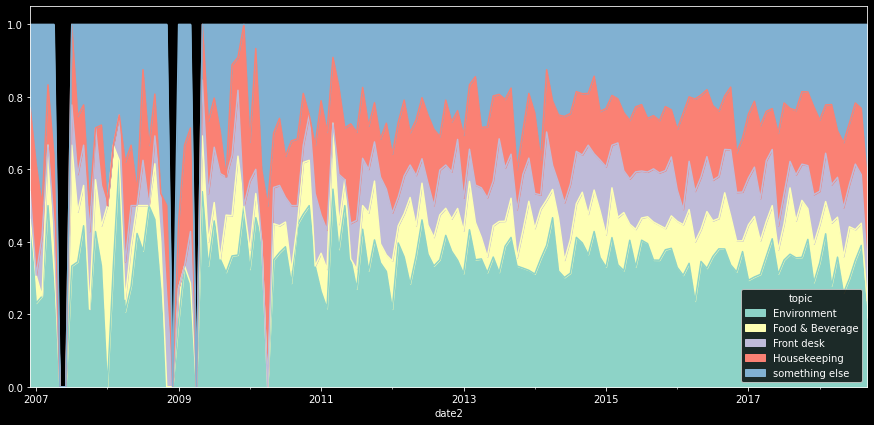

In [170]:
cat.plot(kind='area')

It seems the proportion holds through time. While is very noisy. Let's simplify it a bit by just checking the latest year.

<AxesSubplot:xlabel='date2'>

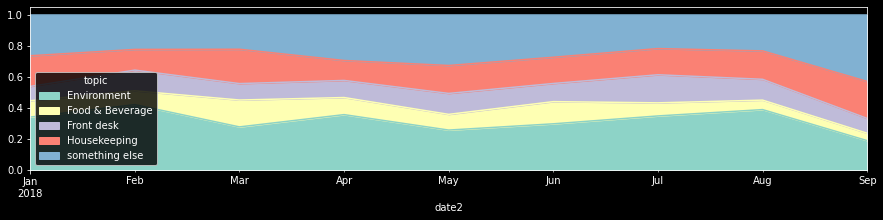

In [171]:
#cat.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#cat.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#cat.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#cat.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
cat.loc['2018':'2018',:].plot(kind='area',figsize=(15,3))

It seems that something else is becoming more important in comments. But also Housekeeping. Probably should explore that content with other algorithms.

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But there are other options available. For instances, We could do some topic modeling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

Fist we need to determinate the proper numer of topics. As this is a unsupervised technique, we can only use some heuristics. To do so, I will use perplexiy and coherence score.

In [110]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus,id2word=common_dictionary, num_topics=20)

In [111]:
lda.print_topics()

[(0,
  '0.041*"service" + 0.021*"holiday" + 0.019*"disappointed" + 0.018*"room" + 0.018*"say" + 0.018*"enjoyed" + 0.017*"pool" + 0.014*"resort" + 0.012*"received" + 0.011*"five_star"'),
 (1,
  '0.040*"room" + 0.039*"spa" + 0.035*"kitchen" + 0.026*"full" + 0.020*"bath" + 0.017*"relax" + 0.014*"one" + 0.013*"bathroom" + 0.012*"would" + 0.012*"laundry"'),
 (2,
  '0.032*"pool" + 0.027*"resort" + 0.023*"lovely" + 0.022*"would" + 0.019*"room" + 0.018*"swim" + 0.015*"like" + 0.015*"recommend" + 0.015*"luxurious" + 0.014*"chairs"'),
 (3,
  '0.065*"stayed" + 0.055*"apartment" + 0.042*"bedroom" + 0.039*"nights" + 0.028*"penthouse" + 0.024*"spa" + 0.023*"two" + 0.020*"swim" + 0.019*"room" + 0.016*"bbq"'),
 (4,
  '0.039*"pool" + 0.027*"price" + 0.019*"bus" + 0.017*"bar" + 0.017*"good" + 0.016*"swim" + 0.014*"one" + 0.012*"checked" + 0.012*"room" + 0.010*"time"'),
 (5,
  '0.036*"dinner" + 0.035*"breakfast" + 0.035*"restaurant" + 0.030*"service" + 0.022*"check" + 0.018*"food" + 0.017*"half" + 0.016*

In [173]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, common_corpus,common_dictionary, mds='tsne')
panel

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

In [112]:
from gensim.models import CoherenceModel

cm_lda = CoherenceModel(model=lda, texts=text, dictionary=common_dictionary, coherence='c_v')
cm_lda.get_coherence()

0.3392437437698705

Ok, topics seems to be very well defined (no superpositions), but coherence is very low. Let's try something else like mallet LDA implementation.

In [175]:
gensim.__version__

'4.1.2'

In [174]:
#import os
#os.environ.update({'MALLET_HOME': 'C:\\Users\\Cami\\Google Drive\\Python\\mallet-2.0.8\\'})
mallet_path = '../Python/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=common_corpus, num_topics=20, id2word=common_dictionary)

AttributeError: module 'gensim.models' has no attribute 'wrappers'

In [75]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, 
                                                        corpus=common_corpus, texts=text, 
                                                        start=2, limit=60, step=6)

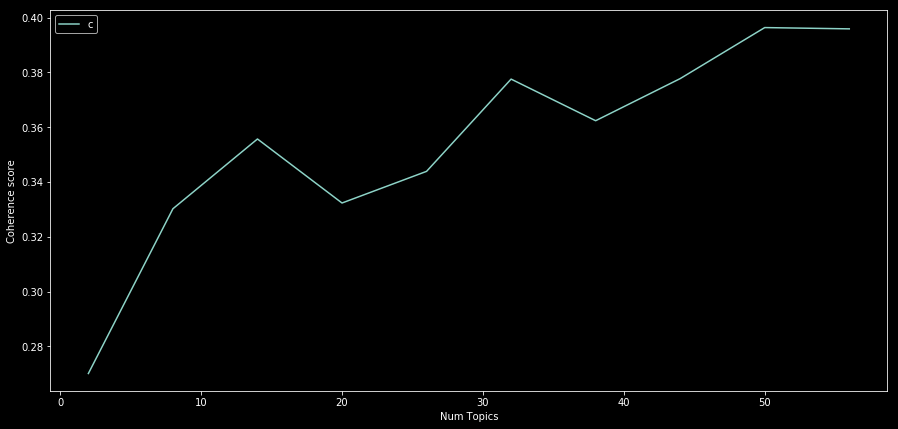

In [79]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.pyplot.plot(x, coherence_values)
plt.pyplot.xlabel("Num Topics")
plt.pyplot.ylabel("Coherence score")
plt.pyplot.legend(("coherence_values"), loc='best')
plt.pyplot.show()

In [89]:
coherence_values

[0.2700604357084412,
 0.3302164234718128,
 0.3556920877298454,
 0.33231702048866174,
 0.3438712329989734,
 0.3775567227500704,
 0.36236287747638657,
 0.37774329045460403,
 0.39637218691108556,
 0.39590539734510155]

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [176]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [177]:
nltk_results = dm3.sent.apply(nltk_sentiment)
results_df = pd.DataFrame(nltk_results.tolist())
#text_df = pd.DataFrame(dataset, columns = ['text'])
dm4 = dm3.join(results_df)
#dm4['date2'] = pd.to_datetime(dm4.date,format='%d %B %Y')
dmds = dm4.copy()
dmds.set_index(pd.DatetimeIndex(dmds['date2']), inplace=True)
dmds = dmds.sort_index()

### Global sentiment by category

<AxesSubplot:title={'center':'compound'}, xlabel='[topic]'>

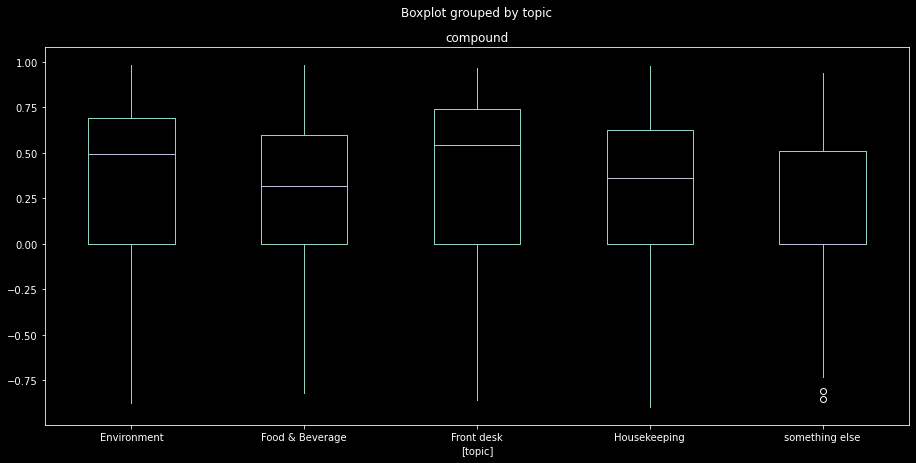

In [178]:
dmds[['topic', 'compound']].boxplot(by='topic',grid=False)

### Sentiment by time and category

In [179]:
sen = pd.pivot_table(dmds, values='compound', index=dmds.index, columns=['topic'], aggfunc=np.mean)
sen = sen.resample(rule='M').mean()

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/1096954557.py:1: UserWarning: Parsing '31/12/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sen[sen.index>pd.to_datetime("31/12/2013")].plot(kind='line')


<AxesSubplot:xlabel='date2'>

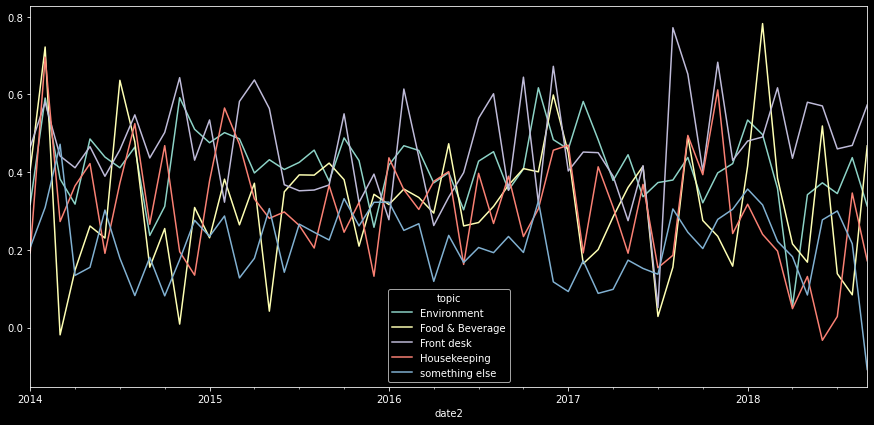

In [180]:
sen[sen.index>pd.to_datetime("31/12/2013")].plot(kind='line')

<AxesSubplot:xlabel='date2'>

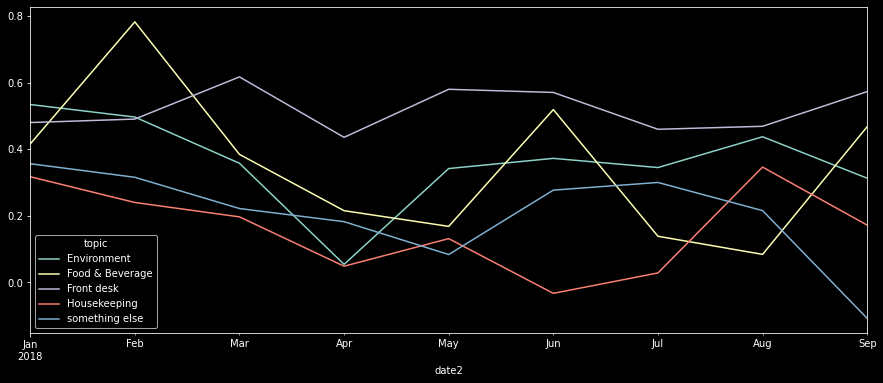

In [181]:
#sen.loc['2014':'2014',:].plot(kind='line', figsize=(12,3))
#sen.loc['2015':'2015',:].plot(kind='line', figsize=(12,3),legend=False)
#sen.loc['2016':'2016',:].plot(kind='line', figsize=(12,3))
#sen.loc['2017':'2017',:].plot(kind='line', figsize=(12,3),legend=False)
sen.loc['2018':'2018',:].plot(kind='line', figsize=(15,6))

Positive sentiments are more likely for every aspect but the most important takeaway here is variation. Both graphs show a lot of noise. Let's clear it out a bit.

### Seasonal Decomposition

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/1510378820.py:2: UserWarning: Parsing '31/12/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  serie = sen[sen.index>pd.to_datetime("31/12/2013")]


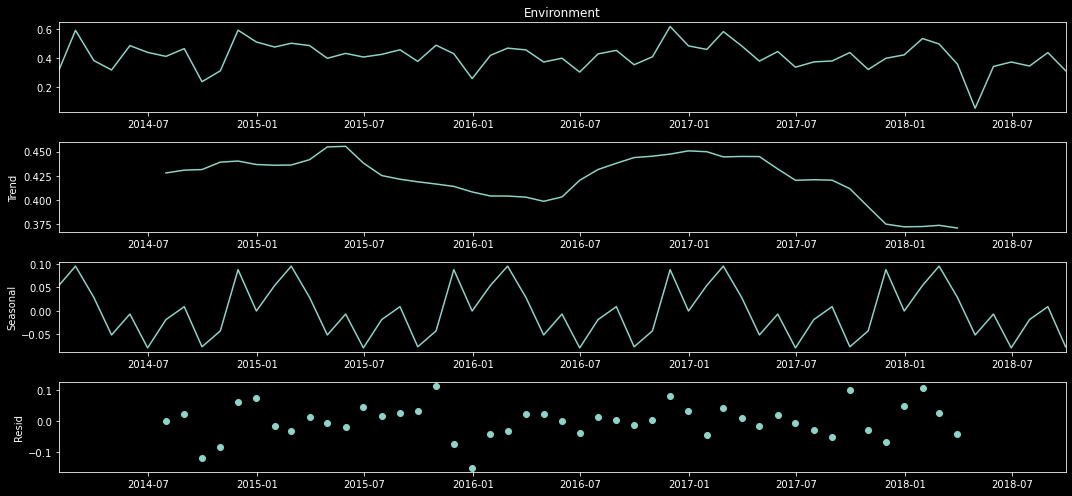

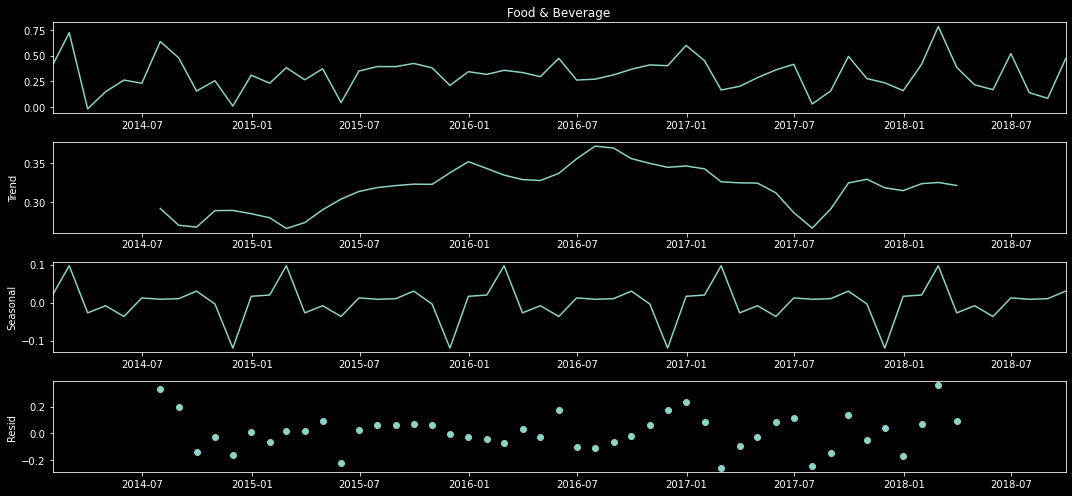

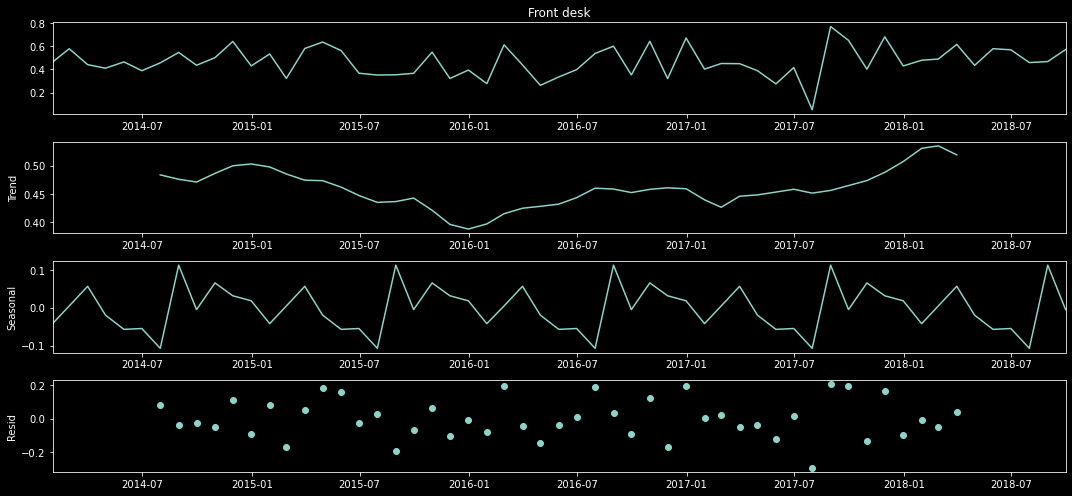

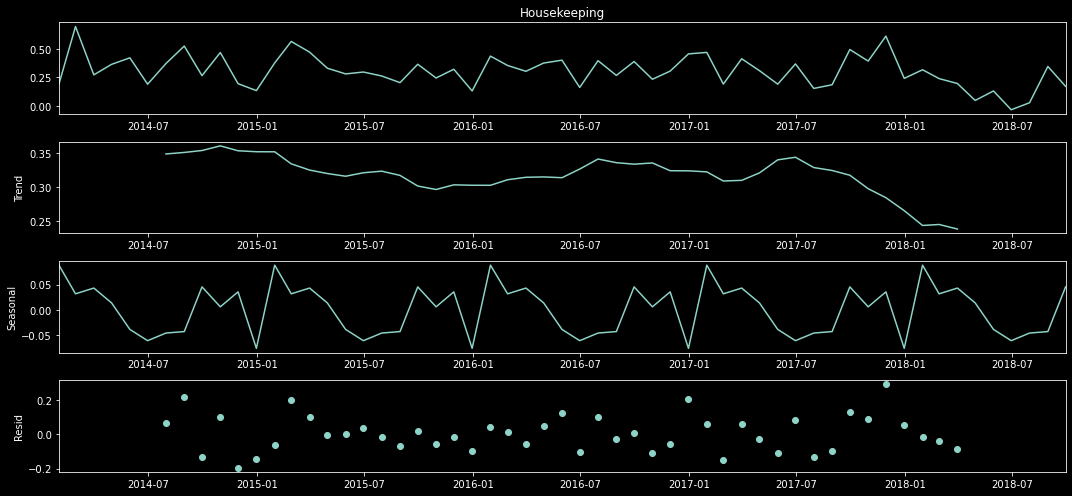

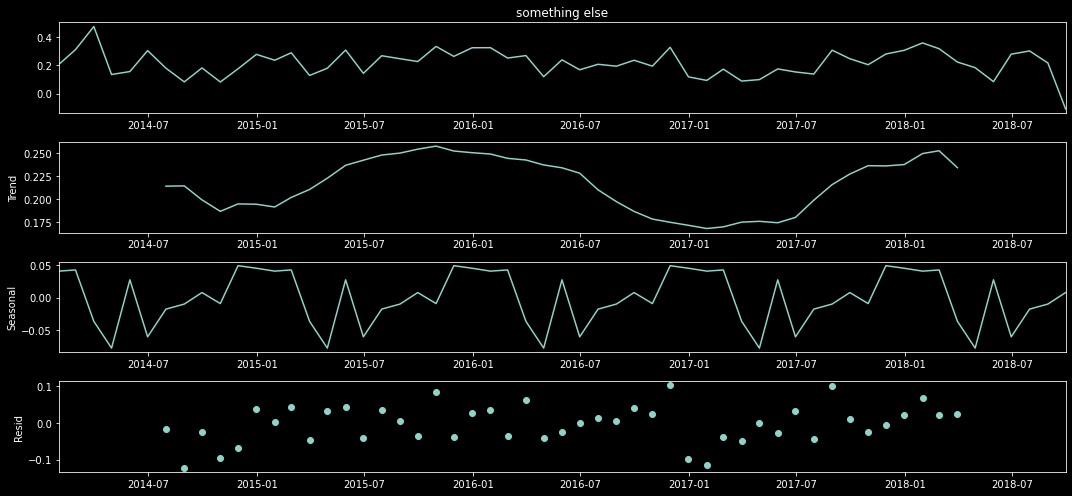

In [182]:
from statsmodels.tsa.seasonal import seasonal_decompose
serie = sen[sen.index>pd.to_datetime("31/12/2013")]
for i in sen.columns:
    result = seasonal_decompose(serie[i], model='additive')
    result.plot()


OK, this looks interesting. Sentiment are seasonal and doesn't show a trend. Except for "Enviroment," which is becoming more and more negative. It kind of makes sense that Enviromnent get lower score over time as infraestructure becomes old and regular customers get used to, for instance, the pool. It doesn't plays an important part of their experience any more.

In the other hand, housekeeping is very seasonal (very positive at the begining of the year, flat the rest of the year.

## Validation

In [146]:
dm3.columns

Index(['index', 'sent', 'title', 'score', 'comment', 'date', 'new_col',
       'keywords', 'topic', 'probability', 'date2'],
      dtype='object')

In [183]:
dm3.score.value_counts()

5.0    4822
4.0    2791
3.0    1205
2.0    440 
1.0    278 
Name: score, dtype: int64

<AxesSubplot:title={'center':'score'}, xlabel='[topic]'>

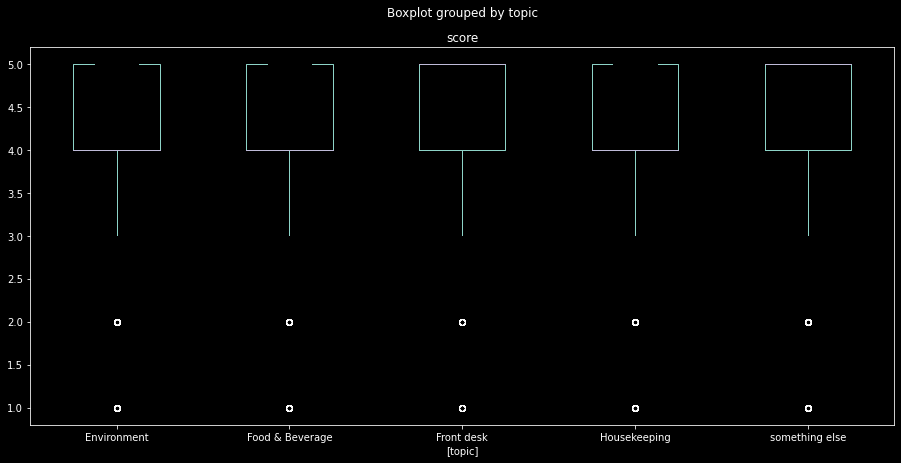

In [147]:
dm3[['topic', 'score']].boxplot(by='topic',grid=False)

## Conclusions

We can summarise the main take away as:

- Seasonality put crate pressure over both Food and beverage and Housekeeping
- It is important to considere that one of the most important features of the PPD is the swiming pool and other enviromental and infrastructure factors, and those may need renewal

There are many more thing that can be done with this dataset. we could go deeper with the topics and try to identify subtopics.